## HeatMap + Prediction - inception_Resnet_V2

In [74]:
from keras.models import load_model
from tensorflow import keras
import tensorflow as tf
from IPython.display import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 

## 모델 불러오기

In [75]:
model = load_model('/content/drive/My Drive/인공지능 학습관련/covid_model_size299_best.h5')
feature_model = load_model('/content/drive/My Drive/인공지능 학습관련/feature_model299.h5')

## 함수들

In [79]:
# 이미지 전처리
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

#  히트맵 생성
def make_gradcam_heatmap(img_path, classifier_model, last_conv_layer_model):
    img_size = (299, 299)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))


    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # 보정 -- 이미지의 최 외곽부 모두 0
    a = np.vstack((np.zeros(heatmap[:2].shape),heatmap[2:-1]))
    a = np.vstack((a[:-1],np.zeros(heatmap[-1:].shape)))
    for i in a:
        i[0] = 0
        i[-1] = 0
    heatmap = a

    return heatmap

# 감마보정
# gamma correction 
def gamma_correction(img, c=1, g=2.2): 
    out = img.copy() 
    out /= 255. 
    out = (1/c * out) ** (1/g) 
    out *= 255 
    out = out.astype(np.uint8) 
    return out 

# CAM이미지 + 원본
def show_CAM(img_path, heatmap, prediction):
    # We load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("Reds")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # gamma correction
    jet_heatmap = gamma_correction(jet_heatmap, g=2.2)

    # Superimpose the heatmap on original image
    if prediction =='NORMAL':
        superimposed_img = img
    else:
        superimposed_img = jet_heatmap *0.5 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# 예측함수
def predict_CXR(image_path):
    
    # 이미지를 불러옴
    img = cv2.imread(image_path)
    # 이미지 크기를 모델에 맞게 조정
    img = cv2.resize(img, dsize=(299,299))
    # 이미지 픽셀값 스케일링
    img = img / 255.0
    # 이미지 차원 확장 (224,224,3) -> (1,224,224,3)  : feature_model에 넣기위함
    img = np.expand_dims(img, axis=0)
    # feature_model에서 feature 추출
    feature_vector = feature_model.predict(img)
    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]
    # print(prediction)
    
    unique_sorted_Y = ['COVID','NORMAL','PNEUMONIA']
    #확률의 예측값을 5개 선출 
    # 가장 예측값이 높은 인덱스를 반환
    index = prediction.argmax()

    # labels에 저장 
    label = unique_sorted_Y[index]
    # print(label)
    return label

## 실행부분

PNEUMONIA PNEUMONIA
NORMAL NORMAL
NORMAL NORMAL
NORMAL NORMAL
NORMAL NORMAL
NORMAL NORMAL
COVID COVID
COVID COVID
PNEUMONIA PNEUMONIA
PNEUMONIA PNEUMONIA


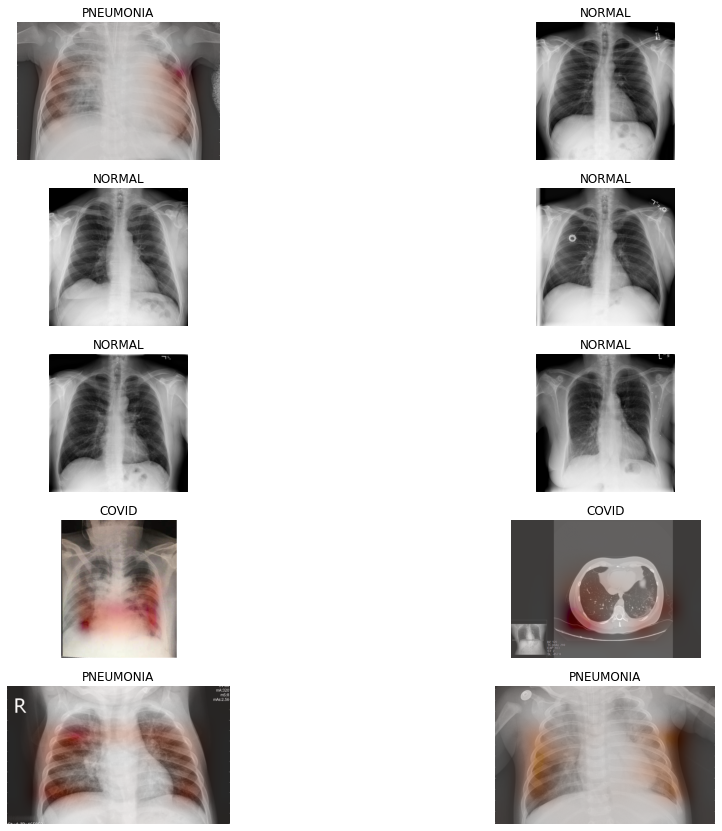

In [80]:
from keras.applications.inception_resnet_v2 import preprocess_input
import random

img_size = (299, 299)
iter = 10
plt.figure(figsize=(16,iter*3))
predictY = []
realY = []


for i in range(iter):
    # The local path to our target image
    img_path = random.choice(valid_generator.filepaths) # --> 실행시키려면 아래의 셀을 실행시켜야한다.

    # img_path = '/content/covid.jpg'
    # split('/')를 통해 나눠진 부분 중 3번째 획득
    real_y = img_path.split('/')[-2]

    # prediction
    prediction = predict_CXR(img_path)


    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_path, model, feature_model)


    # Display heatmap
    # plt.matshow(heatmap)
    # plt.show()


    # Calss Activation Map with image
    cam_image = show_CAM(img_path, heatmap, prediction)
    plt.subplot(iter, 2, i+1)
    plt.imshow(cam_image)
    plt.title(prediction)
    plt.axis('off')

    #  # Save the superimposed image
    save_path = "CXR_cam.jpg"
    cam_image.save(save_path)
    
    predictY.append(prediction)
    realY.append(real_y)
    print(prediction, real_y)



valid_data_path를 가져오기 위한 코드


In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 1
valid_size = 1
# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
# seed 값이 같으므로 train subset과 validation subset이 중복될 일은 없다.
# batch_size = 32, shuffle=True이므로 랜덤하게 32개의 이미지를 디렉토리에서 골라서 보강하여 반환한다.
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/covid데이터', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/covid데이터',
                                                    subset = 'validation',
                                                    batch_size = valid_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))
print(train_generator.n)
print(valid_generator.n)
